## Determining the Effect of Needle Geometry and Polymer in the Systemic Delivery of Drugs from Dissolving Microneedle Patches

The objective of this code is to first model the drug release process from a disoslving microneedle until it reaches the blood plasma, followed by a sensitivy analysis in which the determines the most important factors in the MN design. 

Installing packages needed:

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import pandas as pd
import seaborn as sns

I started the model by modelling the release of Naloxone Hydrochloride from Puri et al. ""Microneedle-mediated transdermal delivery of naloxone hydrochloride for treatment of opioid overdose"

In [90]:
#list of constants here
theta = 0.244 #in radians (0 - 0.7853)
rho =  1.15*10**9 #in ng/mL
h =  0.047 #in cm
r = 0.01 #radius microneedle cm
cs = 1.6*10**8 #in ng/mL
beta = 0.0715 #unitless 0-1
kd = 0.0033 #cm/s
gamma = 1.2 #unitless
nMN = 100 #number of needles in patch
Vs = 0.064 #mL volume of skin compartment
Vn = (1/3)*math.pi*r**2*h #volume of 1 microneedle in mL - cm3
Bbp = 0.8 #size of side base plate 
hbp = 0.26 #height of base pair
Vbp =  Bbp*hbp #volume baseplase in mL or cm3
diff = 0.003  #drug diffusivity cm2/s
dose = 1.78*10**7
doseMN = beta*Vn*rho
doseBP = beta*Vbp*rho
hderm = 0.1 #thickness of dermis in cm
Clb = 2.07*10**5 #systemic clearance of drug
Vb = 1.21*10**4 #volume of distribution blood in mL

Here we start defining all the differential equations that govern the system:

### Equation for the Rate Dissolution of the MN and its Drug Release per Time

First, an equation for the difference in height of the needle was created by correlating height to mass dissolved:

$$M_{d,\text{MN}}(t) = \rho \cdot \pi \cdot \tan^{2}(\theta) \cdot \left( \frac{\Delta z(t)^{3}}{3} \right)$$

Then, an equation for change in surface area of the needle:

$$A(t) = \pi \cdot \frac{\tan \theta}{\cos \theta} \cdot \left( h^{2} - \Delta z(t)^{2} \right) + \pi \cdot \tan^{2} \theta \cdot \Delta z(t)^{2}$$

Lastly, the complete mass balance for the dissolving microneedle. The piecewise section is to ensure that the model knows that it should stop the drug release term once the all drug has been released. This control is added further in code through an if statement, during the ODE system function. 

$$\frac{dM_d(t)}{dt} = \beta \cdot k_D \cdot A(t) \cdot \left( c_s - \underbrace{\left(\frac{1-\beta}{\beta}\right) \cdot c(t)}_{\text{Conc. of polymer in skin}} \right)$$

In [91]:
def eqn_rate_drug_release_MN(DRMN_time, theta, rho, h, cs, DCS_time, beta, kd):
    A = beta * rho * np.pi * (np.tan(theta))**2  
    deltaZMN = (3 * DRMN_time / A) ** (1/3)
    deltaZMN = np.minimum(deltaZMN, h)  # Cap at needle height
    
    area_DMN = (np.pi * np.tan(theta) / np.cos(theta) * (h**2 - deltaZMN**2) 
                + np.pi * (deltaZMN * np.tan(theta))**2)
    area_DMN = np.maximum(area_DMN, 0)
    
    dDRMNdt = beta * kd * area_DMN * (cs - ((1 - beta) / beta) * DCS_time)
    dDRMNdt = np.maximum(dDRMNdt, 0)
    return dDRMNdt

### Equation for the Rate of Dissolution of the Baseplate and its Drug Release per Time

We assume that the drug from the baseplate difussed into the skin through the pore generated by the MNs. First the equation that correlated height of the baseplate in respect to time, correlated with mass of dissolved baseplate:

$$M_{d,\text{BP}}(t) = \rho \cdot b_{\text{BP}}^{2} \cdot \Delta z(t)
$$

Then, a surface area per time equation:

$$A_{\text{BP}}(t) = 4 \cdot b_{\text{BP}} \cdot \left( h_{\text{BP}} - \Delta z(t) \right) + b_{\text{BP}}^{2}
$$

Lastly, the mass balance for dissolving baseplate:

$$\frac{dDRBP}{dt} = \beta \cdot k_d \cdot A_{BP} \cdot \left( c_s - \frac{1-\beta}{\beta} \cdot c(t) \right)$$

In [92]:
def eqn_rate_drug_release_BP(DRBP_time, rho, Bbp, DCS_time, beta, kd, hbp, cs):
    deltaZBP = DRBP_time / (beta * rho * Bbp**2) 
    deltaZBP = float(deltaZBP)
    # Constant contact area until fully dissolved
    if deltaZBP >= hbp:
        area_DBP = 0.0
    else:
        area_DBP = Bbp**2
    
    dDRBPdt = beta * kd * area_DBP * (cs - ((1 - beta) / beta) * DCS_time)
    dDRBPdt = np.maximum(dDRBPdt, 0)
    return dDRBPdt

### Rate Influx of Drug Released from the Baseplate into the Skin per Time

Here we use Fick's law of diffusion:

$$\frac{d M_{i,\text{BP}}(t)}{d t} = \frac{2 \cdot D \cdot N \cdot \pi r^{2}}{h_{\text{derm}} + h_{\text{BP}}} \cdot \left( \frac{M_{d,d,\text{BP}}(t)}{V_{\text{BP}}} - c \right)
$$

In [93]:
def eqn_rate_flux_drugBP_2skin(nMN, diff, hderm, hbp, DBP, Vbp, DCS_time, r,dDRBPdt):
    CBP = DBP / Vbp  # Actual concentration in dissolved pool
    dFDBPS = (2 * diff * nMN * np.pi * r**2) / (hderm + hbp) * (CBP - DCS_time)
    
    dDBP_dt = dDRBPdt - dFDBPS
    return [dFDBPS, dDBP_dt]

### Equation for the Change in Concentration in the Skin per Time

Drug concentration in the skin is given by the drug influx from MN and patch, along with the drug absorption into the plasma. Gamma is the rate of drug absorption. 

$$\frac{d c(t)}{d t} = \underbrace{\frac{N}{V_s} \cdot \left( \frac{d M_d(t)}{d t} \right)}_{\text{from MN}} + \underbrace{\frac{1}{V_s} \cdot \left( \frac{d M_{i,\text{BP}}(t)}{d t} \right)}_{\text{from BP}} - \underbrace{\gamma \cdot c(t)}_{\text{into plasma}}
$$

In [94]:
#function for rate of change of drug concentration in skin
def eqn_rate_drug_concentration_skin(nMN,Vs,gamma, dDRMNdt,dFDBPS, DCS_time):
    # look here
    temp1 = nMN/Vs*(dDRMNdt)
    temp2 = np.array(dFDBPS)/Vs
    temp3 = gamma*DCS_time
    dDCSdt = temp1 + temp2 - temp3
    return dDCSdt

### Equation of Concentration Change in Plasma Per Time

This system uses a one-comaprtment pharmacokinetic model, meaning that all the drug will reach the plasma compartment at some time. There are classes of drugs in which the one-compartment model is not appropriate, since the drug diffuses to oher peripheral compartments. For this model we have decided simplity since it is difficult to estimate intercompartment mass transfer rate. 

$$\frac{d c_B(t)}{d t} = \frac{V_s}{V_b} \cdot \gamma \cdot c(t) - \frac{1}{V_b} \cdot \left( Cl_b \cdot c_b(t) + Q_{\text{per}} \cdot c_b(t) - Q_{\text{per}} \cdot c_{\text{per}}(t) \right)
$$

In [95]:
def eqn_change_DCP(DCS_time, Vs, Vb, gamma, Clb, DCP_time):
    dDCPdt = (gamma * Vs * DCS_time - Clb * DCP_time) / Vb
    return dDCPdt

Now all differential equation functions have been defined. 

In [96]:
#creating variables for the total amount of drug within MN and BP compartments to be used 
#in the piecewise function 
controlMN = beta * rho * nMN * Vn   # Total drug in all microneedles
controlBP = beta * rho * Vbp         # Total drug in baseplate

### Generating the System of ODEs 

In [97]:
def system_of_odes(t, y):
    DRMN_time, DRBP_solid, DBP_time, DCS_time, DCP_time = y
    # DRMN_time:  cumulative drug released from MN solid (ng)
    # DRBP_solid: cumulative drug released from BP solid (ng)
    # DBP:        dissolved drug currently in BP pool (ng)
    # DCS_time:   drug concentration in skin (ng/mL)
    # DCP_time:   drug concentration in plasma (ng/mL)
    
    # Microneedle dissolution (directly into skin)
    dDRMNdt = eqn_rate_drug_release_MN(DRMN_time, theta, rho, h, cs, DCS_time, beta, kd)
    if DRMN_time >= controlMN:
        dDRMNdt = 0
    
    # Baseplate solid dissolution (into BP dissolved pool)
    dDRBPdt = eqn_rate_drug_release_BP(DRBP_solid, rho, Bbp, DCS_time, beta, kd, hbp, cs)
    if DRBP_solid >= controlBP:
        dDRBPdt = 0
    
    # Flux from BP dissolved pool to skin (uses DBP, not DRBP_solid)
    [dFDBPS, dDBP_dt] = eqn_rate_flux_drugBP_2skin(nMN, diff, hderm, hbp, DBP_time, Vbp, DCS_time, r,dDRBPdt)

    
    if DRBP_solid >= controlBP and DBP_time <= 0:
        dFDBPS = 0
    
    # Mass balance for BP dissolved pool: +dissolution, -flux to skin
    dDBPdt = dDRBPdt - dFDBPS
    
    # Skin concentration
    dDCSdt = eqn_rate_drug_concentration_skin(nMN, Vs, gamma, dDRMNdt, dFDBPS, DCS_time)
    
    # Plasma concentration 
    dDCPdt = eqn_change_DCP(DCS_time, Vs, Vb, gamma, Clb, DCP_time)
    
    return [dDRMNdt, dDRBPdt, dDBPdt, dDCSdt, dDCPdt]

Setting the initial valued and calling solve_ivp to solve the system

In [98]:
y0 = [0.0, 0.0, 0.0, 0.0, 0.0]  # [DRMN, DRBP_solid, DBP, DCS, DCP]
t_span = (0.0, 3000.0)
t_eval = np.linspace(0.0, 3000.0, 150)
sol = solve_ivp(system_of_odes, t_span, y0)

Creating plots for the results:

/var/folders/rl/tn37np895gj4hp73lys17b200000gn/T/ipykernel_18534/1234820852.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


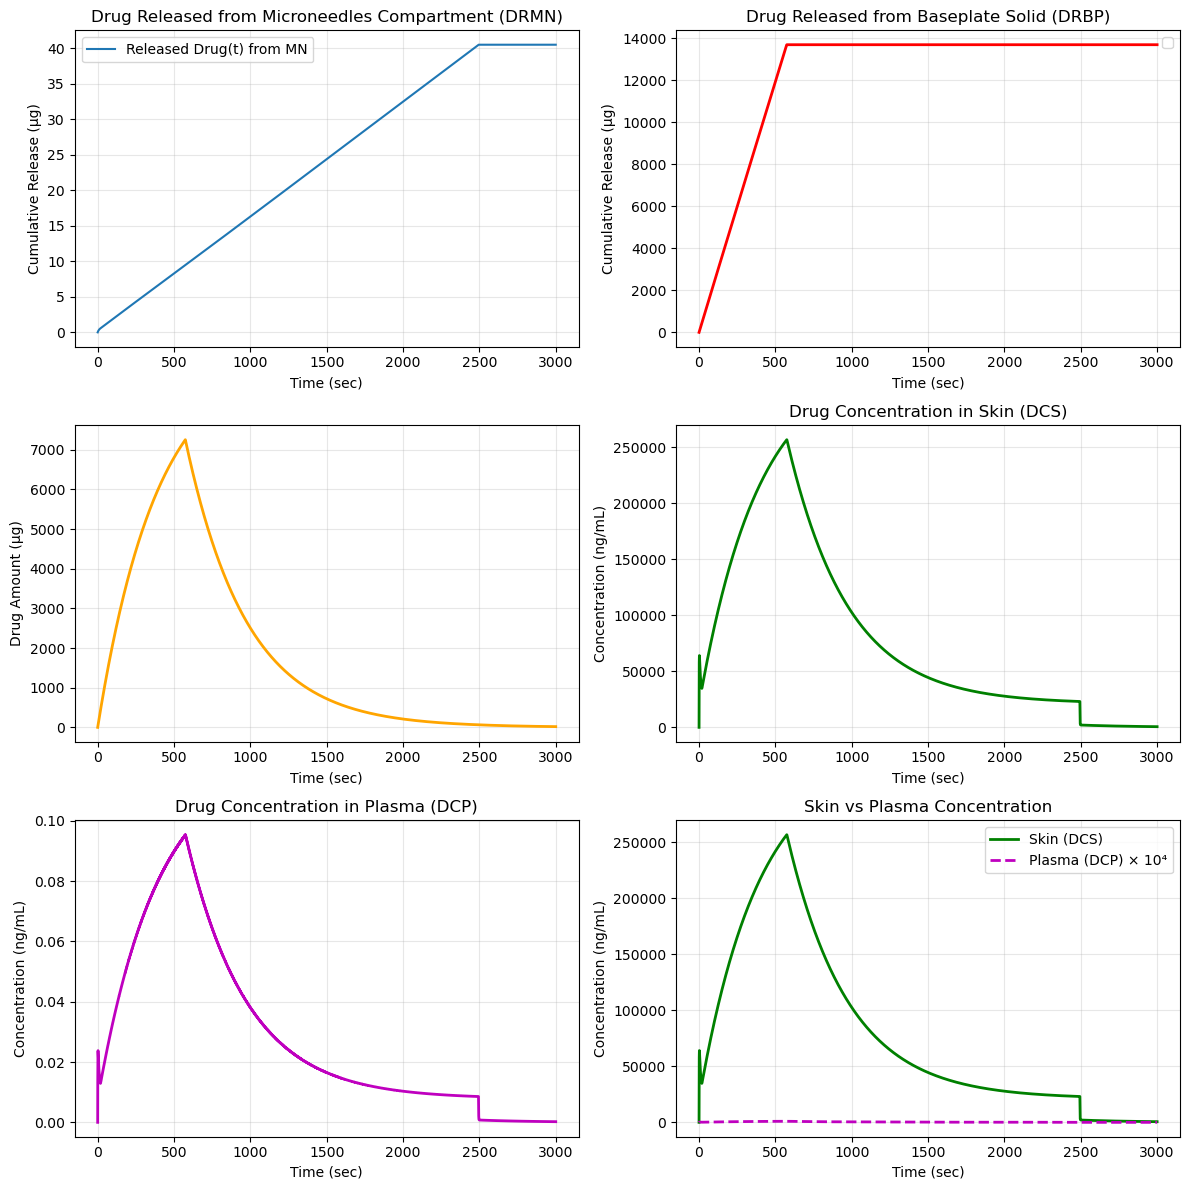


===== SIMULATION SUMMARY =====
Total drug in microneedles: 40.47 µg
Total drug in baseplate: 17.10 mg

At t = 3000.0 hr:
  Drug released from MN: 40.47 µg (100.0%)
  Drug released from BP: 13.6839 mg (80.0%)
  Drug in BP pool: 18.07 µg
  Skin concentration: 589.58 ng/mL
  Plasma concentration: 0.0002 ng/mL


In [99]:
# ============ INDIVIDUAL PLOTS ============
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1: Cumulative drug released from microneedles
axes[0, 0].plot(sol.t, sol.y[0]/1e3, label='Released Drug(t) from MN')
axes[0, 0].set_xlabel('Time (sec)')
axes[0, 0].set_ylabel('Cumulative Release (µg)')
axes[0, 0].set_title('Drug Released from Microneedles Compartment (DRMN)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cumulative drug released from baseplate solid
axes[0, 1].plot(sol.t, sol.y[1]/1e3, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Time (sec)')
axes[0, 1].set_ylabel('Cumulative Release (µg)')
axes[0, 1].set_title('Drug Released from Baseplate Solid (DRBP)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Dissolved drug pool in baseplate
axes[1, 0].plot(sol.t, sol.y[2] / 1e3, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Time (sec)')
axes[1, 0].set_ylabel('Drug Amount (µg)')

axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Drug concentration in skin
axes[1, 1].plot(sol.t, sol.y[3], 'g-', linewidth=2)
axes[1, 1].set_xlabel('Time (sec)')
axes[1, 1].set_ylabel('Concentration (ng/mL)')
axes[1, 1].set_title('Drug Concentration in Skin (DCS)')
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Drug concentration in plasma
axes[2, 0].plot(sol.t, sol.y[4], 'm-', linewidth=2)
axes[2, 0].set_xlabel('Time (sec)')
axes[2, 0].set_ylabel('Concentration (ng/mL)')
axes[2, 0].set_title('Drug Concentration in Plasma (DCP)')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Combined skin and plasma (for comparison)
axes[2, 1].plot(sol.t, sol.y[3], 'g-', linewidth=2, label='Skin (DCS)')
axes[2, 1].plot(sol.t, sol.y[4] * 1e4, 'm--', linewidth=2, label='Plasma (DCP) × 10⁴')
axes[2, 1].set_xlabel('Time (sec)')
axes[2, 1].set_ylabel('Concentration (ng/mL)')
axes[2, 1].set_title('Skin vs Plasma Concentration')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============ PRINT SUMMARY ============
print("\n===== SIMULATION SUMMARY =====")
print(f"Total drug in microneedles: {controlMN/1e3:.2f} µg")
print(f"Total drug in baseplate: {controlBP/1e6:.2f} mg")
print(f"\nAt t = {sol.t[-1]} hr:")
print(f"  Drug released from MN: {sol.y[0][-1]/1e3:.2f} µg ({100*sol.y[0][-1]/controlMN:.1f}%)")
print(f"  Drug released from BP: {sol.y[1][-1]/1e6:.4f} mg ({100*sol.y[1][-1]/controlBP:.1f}%)")
print(f"  Drug in BP pool: {sol.y[2][-1]/1e3:.2f} µg")
print(f"  Skin concentration: {sol.y[3][-1]:.2f} ng/mL")
print(f"  Plasma concentration: {sol.y[4][-1]:.4f} ng/mL")

### Convergence Analysis

The convergence analysis will focus on the the peak in the Drug Plasma Concentration equations. 

STEP-SIZE CONVERGENCE ANALYSIS
Solver: Radau
Analyzing: max value of DBP (index 2)

Computing reference solution with Radau...
Reference solution computed successfully (11755 function evals)
Reference max of DBP: 7.193833e+06 at t = 563.76

Testing step sizes...
  max_step = 300.0: max(DBP) = 7.193818e+06, error = 1.52e+01
  max_step = 60.0: max(DBP) = 7.193833e+06, error = 1.06e-01
  max_step = 30.0: max(DBP) = 7.193833e+06, error = 7.27e-02
  max_step = 15.0: max(DBP) = 7.193833e+06, error = 7.16e-02
  max_step = 6.0: max(DBP) = 7.193833e+06, error = 7.17e-02
  max_step = 3.0: max(DBP) = 7.193833e+06, error = 1.64e-02
  max_step = 1.5: max(DBP) = 7.193833e+06, error = 4.59e-03


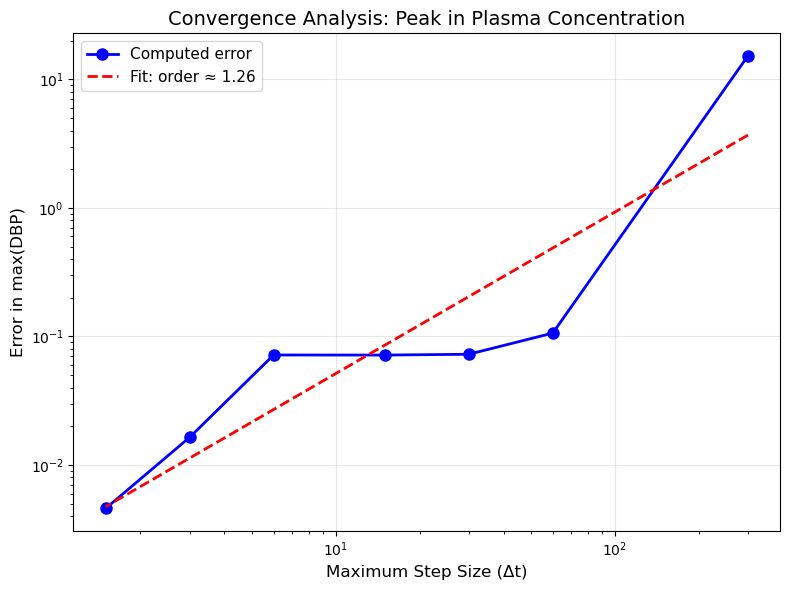


Estimated order of convergence: 1.26


In [100]:
VAR_INDEX = 4
VAR_NAME = "Drug Concentrattion in Plasma ng/mL"

def stepsize_convergence_analysis(system, t_span, y0, t_eval, method='Radau',
                                   var_index=None, var_name=None):
    T = t_span[1] - t_span[0]
    dt_values = [T / n for n in [10, 50, 100, 200, 500, 1000, 2000]]
    
    # Reference solution with stiff solver and tight tolerances
    print("Computing reference solution with Radau...")
    sol_ref = solve_ivp(system, t_span, y0, method='Radau', t_eval=t_eval,
                        rtol=1e-9, atol=1e-11)
    
    if not sol_ref.success:
        print(f"ERROR: Reference solution failed: {sol_ref.message}")
        return None, None, None, None
    
    y_ref = sol_ref.y
    print(f"Reference solution computed successfully ({sol_ref.nfev} function evals)")
    
    # Get reference max value for the variable of interest
    if var_index is not None:
        ref_max = np.max(y_ref[var_index, :])
        ref_max_time = t_eval[np.argmax(y_ref[var_index, :])]
        label = var_name if var_name else f"y[{var_index}]"
        print(f"Reference max of {label}: {ref_max:.6e} at t = {ref_max_time:.2f}\n")
    
    errors = []
    max_values = []
    print("Testing step sizes...")
    for dt in dt_values:
        sol = solve_ivp(system, t_span, y0, method=method, t_eval=t_eval,
                        max_step=dt)
        
        if not sol.success:
            print(f"  max_step = {dt:.1f}: FAILED - {sol.message}")
            errors.append(np.nan)
            max_values.append(np.nan)
        else:
            if var_index is not None:
                # Error in the maximum value of the specified variable
                sol_max = np.max(sol.y[var_index, :])
                error = np.abs(sol_max - ref_max)
                max_values.append(sol_max)
                print(f"  max_step = {dt:.1f}: max({label}) = {sol_max:.6e}, error = {error:.2e}")
            else:
                # Global max error across all variables
                error = np.max(np.abs(sol.y - y_ref))
                print(f"  max_step = {dt:.1f}: error = {error:.2e}")
            errors.append(error)
    
    return dt_values, errors, max_values, ref_max if var_index is not None else None

def plot_stepsize_convergence(dt_values, errors, var_name=None):
    """Plot convergence results for step-size analysis."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    dt_arr = np.array(dt_values)
    err_arr = np.array(errors)
    
    # Filter out zero/nan errors for log plotting
    mask = (err_arr > 1e-16) & ~np.isnan(err_arr)
    
    if np.sum(mask) < 2:
        print("\nNot enough valid data points for convergence analysis.")
        return None
    
    ax.loglog(dt_arr[mask], err_arr[mask], 'bo-', lw=2, ms=8, label='Computed error')
    
    # Estimate order of convergence
    coeffs = np.polyfit(np.log(dt_arr[mask]), np.log(err_arr[mask]), 1)
    order = coeffs[0]
    fit_line = np.exp(coeffs[1]) * dt_arr[mask]**order
    ax.loglog(dt_arr[mask], fit_line, 'r--', lw=2, label=f'Fit: order ≈ {order:.2f}')
    
    ax.set_xlabel('Maximum Step Size (Δt)', fontsize=12)
    ylabel = f'Error in max({var_name})' if var_name else 'Maximum Error'
    ax.set_ylabel(ylabel, fontsize=12)
    title = f'Convergence Analysis: Peak in Plasma Concentration' if var_name else 'Convergence Analysis'
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('stepsize_convergence.png', dpi=150)
    plt.show()
    
    print(f"\nEstimated order of convergence: {order:.2f}")
    return order

# =============================================================================
# Run the analysis
# =============================================================================
if __name__ == "__main__":
    SOLVER_METHOD = 'Radau'  # Use 'Radau' or 'BDF' for stiff systems
    
    # =========================================================================
    # CONFIGURE WHICH VARIABLE TO ANALYZE
    # =========================================================================
    # Set to None for global error across all variables, or specify:
    #   VAR_INDEX: 0=DRMN, 1=DRBP_solid, 2=DBP, 3=DCS, 4=DCP
    #   VAR_NAME: display name for plots
    VAR_INDEX = 2       # e.g., focus on DBP (index 2)
    VAR_NAME = "DBP"    # name for plot labels
    # =========================================================================
    
    print("=" * 60)
    print("STEP-SIZE CONVERGENCE ANALYSIS")
    print(f"Solver: {SOLVER_METHOD}")
    if VAR_INDEX is not None:
        print(f"Analyzing: max value of {VAR_NAME} (index {VAR_INDEX})")
    else:
        print("Analyzing: global max error across all variables")
    print("=" * 60 + "\n")
    
    dt_vals, errors, max_vals, ref_max = stepsize_convergence_analysis(
        system_of_odes, t_span, y0, t_eval, 
        method=SOLVER_METHOD,
        var_index=VAR_INDEX,
        var_name=VAR_NAME
    )
    
    if dt_vals is not None:
        order = plot_stepsize_convergence(dt_vals, errors, var_name=VAR_NAME)

### Sensitivity Analysis

Starting with an 1 at a time approach. 1000 simulations with varying paramters were run and results plotted. Here is how the input data set was created:

In [101]:
num_sim = 1000
#make random data
beta_vals = np.random.uniform(0.01, 0.2, num_sim)
rho_vals = np.random.uniform(1e6, 2e10, num_sim)
h_vals = np.random.uniform(0.04, 0.4, num_sim)
r_vals = np.random.uniform(0.005, 0.04, num_sim)
theta_vals = np.random.uniform(0.1, 0.7853, num_sim)
hbp_vals = np.random.uniform(0.1, 0.5, num_sim)
diff_vals = np.random.uniform(0.01, 10.0, num_sim)
kd_vals = np.random.uniform(0.001, 0.02, num_sim)
nMN_vals = np.random.randint(50, 500, num_sim)
cs_vals = np.random.uniform(1e4, 1e7, num_sim)  

data = np.array([beta_vals, rho_vals, h_vals, r_vals, theta_vals, hbp_vals, diff_vals, kd_vals, nMN_vals, cs_vals])

data.shape

(10, 1000)

In order to introduce the np arrays into the system of ODEs, small modications to the input arguments had to be made. So here's the sma eODE system generator:

In [102]:
def system_of_odes_vals(t, y, beta_vals, rho_vals, h_vals, r_vals, theta_vals, hbp_vals, diff_vals, kd_vals, nMN_vals, cs_vals):
    DRMN_time, DRBP_solid, DBP_time, DCS_time, DCP_time = y
    # DRMN_time:  cumulative drug released from MN solid (ng)
    # DRBP_solid: cumulative drug released from BP solid (ng)
    # DBP:        dissolved drug currently in BP pool (ng)
    # DCS_time:   drug concentration in skin (ng/mL)
    # DCP_time:   drug concentration in plasma (ng/mL)
    
    # Microneedle dissolution (directly into skin)
    dDRMNdt = eqn_rate_drug_release_MN(DRMN_time, theta_vals, rho_vals, h_vals, cs_vals, DCS_time, beta_vals, kd_vals)
    if DRMN_time >= controlMN:
        dDRMNdt = 0
    
    # Baseplate solid dissolution (into BP dissolved pool)
    dDRBPdt = eqn_rate_drug_release_BP(DRBP_solid, rho_vals, Bbp, DCS_time, beta_vals, kd_vals, hbp, cs_vals)
    if DRBP_solid >= controlBP:
        dDRBPdt = 0
    
    # Flux from BP dissolved pool to skin (uses DBP, not DRBP_solid)
    [dFDBPS, dDBP_dt] = eqn_rate_flux_drugBP_2skin(nMN_vals, diff_vals, hderm, hbp_vals, DBP_time, Vbp, DCS_time, r_vals,dDRBPdt)

    
    if DRBP_solid >= controlBP and DBP_time <= 0:
        dFDBPS = 0
    
    # Mass balance for BP dissolved pool: +dissolution, -flux to skin
    dDBPdt = dDRBPdt - dFDBPS
    
    # Skin concentration
    dDCSdt = eqn_rate_drug_concentration_skin(nMN_vals, Vs, gamma, dDRMNdt, dFDBPS, DCS_time)
    
    # Plasma concentration 
    dDCPdt = eqn_change_DCP(DCS_time, Vs, Vb, gamma, Clb, DCP_time)
    
    return [dDRMNdt, dDRBPdt, dDBPdt, dDCSdt, dDCPdt]



Now we pass all 1000 simulations through the solver. 

In [103]:
results_DRMN = []      # Cumulative MN release
results_DRBP = []      # Cumulative BP release
results_DBP = []       # BP dissolved pool
results_DCS = []       # Skin concentration
results_DCP = []       # Plasma concentration
failed_indices = []

for i in range(num_sim):
    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]  # [DRMN, DRBP_solid, DBP, DCS, DCP]
    t_span = (0.0, 3000.0)

    t_eval = np.linspace(0.0, 3000.0, 15)
    sol = solve_ivp(system_of_odes_vals, t_span, y0, t_eval=t_eval, args=(beta_vals[i], rho_vals[i], h_vals[i], r_vals[i], theta_vals[i], hbp_vals[i], diff_vals[i], kd_vals[i], nMN_vals[i], cs_vals[i]))
    results_DRMN.append(sol.y[0])
    results_DRBP.append(sol.y[1])
    results_DBP.append(sol.y[2])
    results_DCS.append(sol.y[3])
    results_DCP.append(sol.y[4])



Now, to evaluate each simulation, we will find at what time the drug concentration in the plasma was at it highest and how long it took for concentration to reach zero. 

In [117]:

# For each simulation, calculate the time were the peak plasma concentration was reached
peak_DCP = [np.max(cp) for cp in results_DCP]           # Peak plasma concentration
time_to_peak = [t_eval[np.argmax(cp)] for cp in results_DCP]  # Time to peak
AUC_DCP = [np.trapezoid(cp, t_eval) for cp in results_DCP]  # Area under curve (total exposure)

peak_DCS = [np.max(cs) for cs in results_DCS]           # Peak skin concentration
total_released = [dr[-1] for dr in results_DRMN]        # Total drug released from MN

peak_DBP = [np.max(dbp) for dbp in results_DBP]



Scatter plots for the generated simulation data:

IndexError: index 5 is out of bounds for axis 1 with size 5

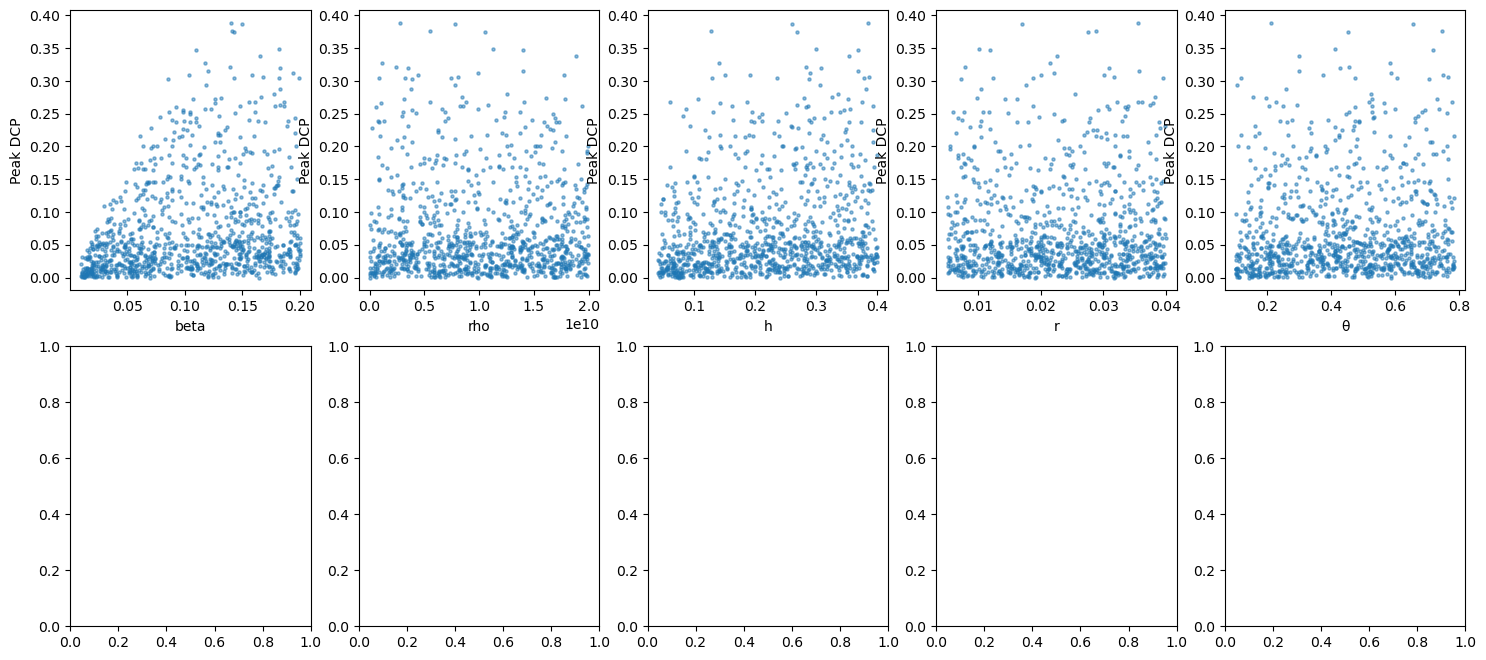

In [118]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

inputs = [beta_vals, rho_vals, h_vals, r_vals, theta_vals, 
          hbp_vals, diff_vals, kd_vals, nMN_vals, cs_vals]
input_names = ['beta', 'rho', 'h', 'r', 'θ', 'h_bp', 'D', 'kd', 'nMN', 'cs']

# Row 1: Peak plasma concentration
for i, (x, name) in enumerate(zip(inputs, input_names)):
    axes[0, i].scatter(x, peak_DCP, alpha=0.5, s=5)
    axes[0, i].set_xlabel(name)
    axes[0, i].set_ylabel('Peak DCP')

# Row 2: AUC
for i, (x, name) in enumerate(zip(inputs, input_names)):
    axes[0, i].scatter(x, AUC_DCP, alpha=0.5, s=5)
    axes[0, i].set_xlabel(name)
    axes[0, i].set_ylabel('AUC')

plt.tight_layout()
plt.show()


I also added a Parameter-Output Correlation Matrix:

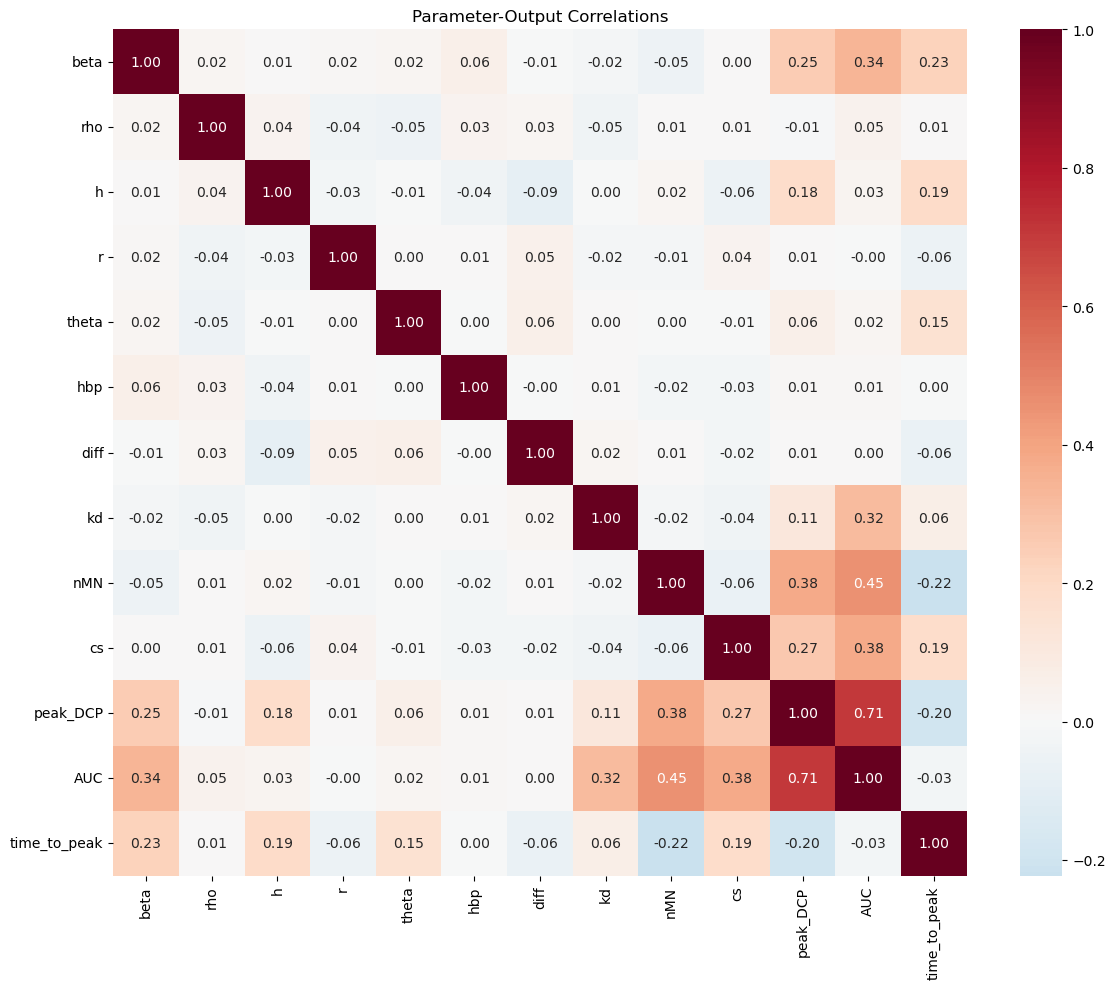

In [119]:
# Combine into dataframe
df = pd.DataFrame({
    'beta': beta_vals, 'rho': rho_vals, 'h': h_vals, 'r': r_vals,
    'theta': theta_vals, 'hbp': hbp_vals, 'diff': diff_vals,
    'kd': kd_vals, 'nMN': nMN_vals, 'cs': cs_vals,
    'peak_DCP': peak_DCP, 'AUC': AUC_DCP, 'time_to_peak': time_to_peak})

# Correlation matrix
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Parameter-Output Correlations')
plt.tight_layout()
plt.show()

Lastly in the one-at-a-time sensitivity analysis, we ranked the variables that affected the size of peak time in plasma concentration and time that it took for peak to happen:

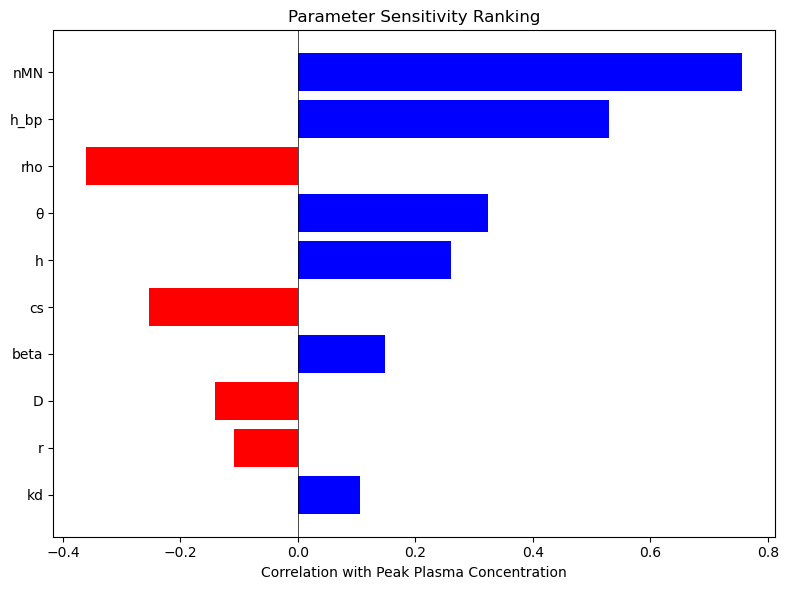

In [107]:
# Correlation of each input with peak plasma concentration
correlations = [np.corrcoef(x, peak_DCP)[0, 1] for x in inputs]

# Sort by absolute value
sorted_idx = np.argsort(np.abs(correlations))
sorted_names = [input_names[i] for i in sorted_idx]
sorted_corr = [correlations[i] for i in sorted_idx]

plt.figure(figsize=(8, 6))
colors = ['red' if c < 0 else 'blue' for c in sorted_corr]
plt.barh(sorted_names, sorted_corr, color=colors)
plt.xlabel('Correlation with Peak Plasma Concentration')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.title('Parameter Sensitivity Ranking')
plt.tight_layout()
plt.show()

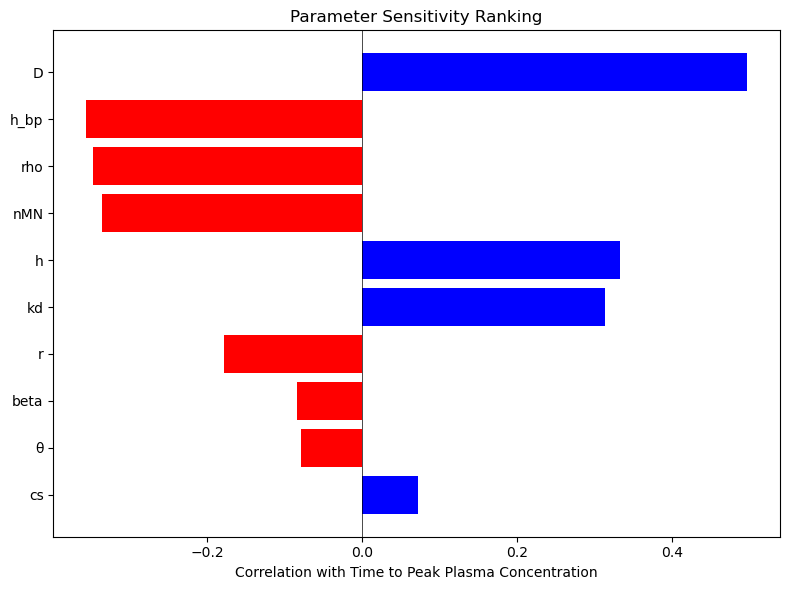

In [108]:
# Correlation of each input with peak plasma concentration
correlations = [np.corrcoef(x, time_to_peak)[0, 1] for x in inputs]

# Sort by absolute value
sorted_idx = np.argsort(np.abs(correlations))
sorted_names = [input_names[i] for i in sorted_idx]
sorted_corr = [correlations[i] for i in sorted_idx]

plt.figure(figsize=(8, 6))
colors = ['red' if c < 0 else 'blue' for c in sorted_corr]
plt.barh(sorted_names, sorted_corr, color=colors)
plt.xlabel('Correlation with Time to Peak Plasma Concentration')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.title('Parameter Sensitivity Ranking')
plt.tight_layout()
plt.show()

### Sensitivity Analysis Using the Morris Method:

In [109]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [110]:
morris_problem = {
    # There are ten variables
    'num_vars': 10,
    # These are their names
    'names': ['beta', 'rho', 'h', 'r', 'theta', 'hbp', 'diff', 'kd', 'nMN', 'cs'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[0.01, 0.2], 
               [1e6, 2e10], 
               [0.04, 0.4], 
               [0.005, 0.04], 
               [0.1, 0.7853], 
               [0.1, 0.5],
               [0.01, 10.0],
               [0.001, 0.02],
               [50, 500],
               [1e4, 1e7]
              ],
    # I don't want to group any of these variables together
    'groups': None
}

In [111]:
morris_problem
ms.sample
num_levels = 4
trajectories = int(1e4)
sample = ms.sample(morris_problem, trajectories, num_levels=num_levels)
sample.shape

(110000, 10)

In [112]:
print(sample.T.shape)
print(sample.T)

(10, 110000)
[[2.00000000e-01 2.00000000e-01 2.00000000e-01 ... 1.00000000e-02
  1.36666667e-01 1.36666667e-01]
 [1.33336667e+10 1.33336667e+10 1.33336667e+10 ... 2.00000000e+10
  2.00000000e+10 2.00000000e+10]
 [2.80000000e-01 2.80000000e-01 2.80000000e-01 ... 4.00000000e-02
  4.00000000e-02 2.80000000e-01]
 ...
 [1.00000000e-03 1.00000000e-03 1.36666667e-02 ... 7.33333333e-03
  7.33333333e-03 7.33333333e-03]
 [2.00000000e+02 2.00000000e+02 2.00000000e+02 ... 5.00000000e+02
  5.00000000e+02 5.00000000e+02]
 [6.67000000e+06 6.67000000e+06 6.67000000e+06 ... 3.34000000e+06
  3.34000000e+06 3.34000000e+06]]


In [113]:
def run_model(params):
    """
    Run the ODE model for a single parameter set.
    
    Parameters
    ----------
    params : array-like
        [beta, rho, h, r, theta, hbp, diff, kd, nMN, cs]
    
    Returns
    -------
    dict : scalar outputs of interest
    """
    beta, rho, h, r, theta, hbp, diff, kd, nMN, cs = params
    
    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]
    t_span = (0.0, 120000.0)
    t_eval = np.linspace(0.0, 120000.0, 500)
    
    sol = solve_ivp(
        system_of_odes_vals, 
        t_span, 
        y0,
        method='Radau',
        t_eval=t_eval,
        max_step=200,
        args=(beta, rho, h, r, theta, hbp, diff, kd, nMN, cs)
    )
    
    if not sol.success:
        # Return NaN if solver fails
        return {'peak_DCP': np.nan, 'AUC': np.nan, 'time_to_peak': np.nan}
    
    DCP = sol.y[4]  # Plasma concentration
    
    return {
        'peak_DCP': np.max(DCP),
        'AUC': np.trapz(DCP, t_eval),
        'time_to_peak': t_eval[np.argmax(DCP)]
    }

# =============================================================================
# Run model for all samples
# =============================================================================
n_samples = sample.shape[0]
print(f"Running {n_samples} simulations...")

# Initialize output arrays
peak_DCP = np.zeros(n_samples)
AUC = np.zeros(n_samples)
time_to_peak = np.zeros(n_samples)

for i, params in enumerate(sample):
    if i % 1000 == 0:
        print(f"  Progress: {i}/{n_samples}")
    
    results = run_model(params)
    peak_DCP[i] = results['peak_DCP']
    AUC[i] = results['AUC']
    time_to_peak[i] = results['time_to_peak']

print("Done!")

Running 110000 simulations...
  Progress: 0/110000


/var/folders/rl/tn37np895gj4hp73lys17b200000gn/T/ipykernel_18534/1322889380.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'AUC': np.trapz(DCP, t_eval),


  Progress: 1000/110000
  Progress: 2000/110000
  Progress: 3000/110000
  Progress: 4000/110000


/opt/miniconda3/envs/comp_mod_class/lib/python3.13/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


  Progress: 5000/110000
  Progress: 6000/110000
  Progress: 7000/110000
  Progress: 8000/110000
  Progress: 9000/110000
  Progress: 10000/110000
  Progress: 11000/110000
  Progress: 12000/110000
  Progress: 13000/110000
  Progress: 14000/110000
  Progress: 15000/110000
  Progress: 16000/110000
  Progress: 17000/110000
  Progress: 18000/110000
  Progress: 19000/110000
  Progress: 20000/110000
  Progress: 21000/110000
  Progress: 22000/110000
  Progress: 23000/110000
  Progress: 24000/110000
  Progress: 25000/110000
  Progress: 26000/110000
  Progress: 27000/110000
  Progress: 28000/110000
  Progress: 29000/110000
  Progress: 30000/110000
  Progress: 31000/110000
  Progress: 32000/110000
  Progress: 33000/110000
  Progress: 34000/110000
  Progress: 35000/110000
  Progress: 36000/110000
  Progress: 37000/110000
  Progress: 38000/110000
  Progress: 39000/110000
  Progress: 40000/110000
  Progress: 41000/110000
  Progress: 42000/110000
  Progress: 43000/110000
  Progress: 44000/110000
  Pro

In [114]:
Si = ma.analyze(morris_problem, 
                sample, 
                time_to_peak, 
                print_to_console=False, 
                num_levels=num_levels)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))


Name                      mu mu_star   sigma
beta                 - 21.57  288.51 2398.93
rho                  - 14.93  296.59 1802.47
h                    - 25.36  304.85 2300.30
r                    -316.89  415.73 2626.98
theta                  45.20  261.41 2054.49
hbp                   101.18  194.46 1961.46
diff                 -371.72  506.63 3251.46
kd                   -  8.15  296.22 2549.12
nMN                  -292.58  403.11 2701.65
cs                     46.68  314.55 1793.43


In [115]:
print("\n--- Sensitivity Analysis: Peak Plasma Concentration ---")
Si_peak = ma.analyze(morris_problem, sample, peak_DCP, num_levels=num_levels)
print(Si_peak)

print("\n--- Sensitivity Analysis: AUC ---")
Si_AUC = ma.analyze(morris_problem, sample, AUC, num_levels=num_levels)
print(Si_AUC)


--- Sensitivity Analysis: Peak Plasma Concentration ---
{'names': array(['beta', 'rho', 'h', 'r', 'theta', 'hbp', 'diff', 'kd', 'nMN', 'cs'],
      dtype='<U5'), 'mu': masked_array(data=[0.04072350909779099, 0.013730184768078326,
                   0.02365019761635693, 0.00035623419706353127,
                   0.01411170794269525, -0.00017705185504873972,
                   0.0002987777663415156, 0.02629902172039475,
                   0.060674176960648, 0.05341703196044189],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20), 'mu_star': masked_array(data=[0.07954752790973028, 0.02025118371806419,
                   0.056482020446060335, 0.0004408455683089521,
                   0.044964093804719656, 0.00020221633113755275,
                   0.0005978739179469857, 0.04879425828908448,
                   0.06067471623973421, 0.08611034744660381],
             mask=[False, False, False, False, False, Fa

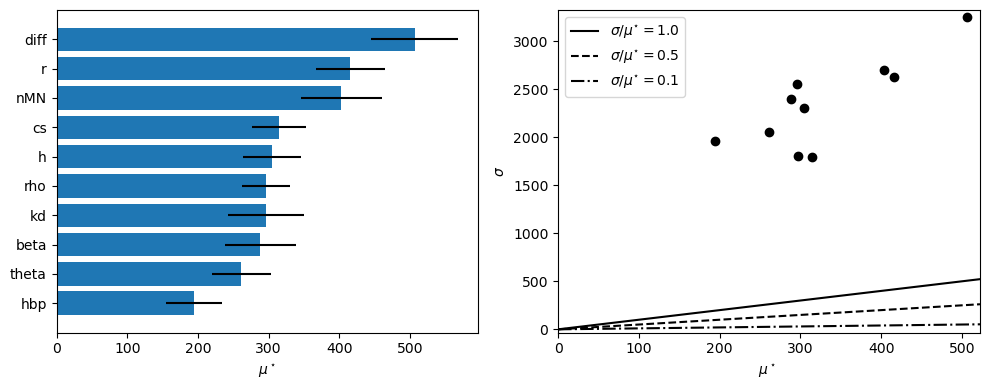

In [116]:
names = ['beta', 'rho', 'h', 'r', 'theta', 'hbp', 'diff', 'kd', 'nMN', 'cs']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

param_dict = {i: name for i, name in enumerate(names)}

# Horizontal bar plot (NO param_dict for older SALib versions)
mp.horizontal_bar_plot(ax1, Si)

# Covariance plot (needs param_dict for labeling)
mp.covariance_plot(ax2, Si, {})

plt.tight_layout()
plt.show()
